In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import ParserError
import cycler
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

### Inputs

In [2]:
# Results directory
results_directory = './full_results/'

subbasin_id= '58308'

gauge_name= 'MREIB'

scenario= 'ssp370' # select ssp245, ssp370 or ssp585

# start and end dates for the calculation of average annual flow
start_date= '2030-01-01'

end_date= '2060-12-31'

# variable
variable= 'cout' 

historical_path= '../0058308.txt'


### Analysis

Future Climate

In [3]:
def process_ensemble(results_directory: str, 
                 subbasin_id: str, 
                 scenario: str, 
                 start_date: str, 
                 end_date: str, 
                 variable: str) -> xr.DataArray:
    # Check for files of required subbasin and scenario
    file_list = [os.path.join(results_directory, filename) for filename in os.listdir(results_directory) if (subbasin_id in filename) and (scenario in filename)]
    
    # Create an empty list to store xarray DataArrays
    data_arrays: List[xr.DataArray] = []

    # Loop through each file
    for file_path in file_list:
        # Read the file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t', index_col=0)

        # Drop the first row
        df = df.iloc[1:]

        # Convert the DataFrame to an xarray DataArray
        data_array = xr.DataArray(df.values, dims=('DATE', 'variable'), coords={'DATE': df.index, 'variable': df.columns})

        # Append the DataArray to the list
        data_arrays.append(data_array)

    # Concatenate the list of DataArrays along a new dimension 'member'
    ds = xr.concat(data_arrays, dim='member')

    # Convert 'DATE' coordinate to datetime, specifying the format and handling errors
    ds['DATE'] = pd.to_datetime(ds['DATE'], format='%Y-%m-%d', errors='coerce')

    # Convert 'member' coordinate to float
    ds = ds.astype(float)

    # Select the specified variable from the dataset
    var_data = ds.sel(variable=variable)

    # Sort the dataset along the 'DATE' coordinate
    var_data = var_data.sortby('DATE')

    # Filter the sorted dataset to include only data between the specified dates
    var_data = var_data.sel(DATE=slice(start_date, end_date))

    # Calculate the mean of these daily means for each member to get the average annual runoff
    average_annual_runoff = var_data.groupby('DATE.dayofyear').mean(dim='DATE')
    
    # shift data to start on november 1st
    # Shift dayofyear to start at 306 and loop around
    dayofyear_shifted = ((average_annual_runoff['dayofyear'] - 306) % 366) + 1

    # Update the 'dayofyear' coordinate with the shifted values
    average_annual_runoff['dayofyear'] = dayofyear_shifted

    # Sort the data_array along the 'dayofyear' coordinate
    average_annual_runoff_shifted = average_annual_runoff.sortby('dayofyear')
    
    return average_annual_runoff_shifted

In [4]:
def process_historical(filepath: str, variable: str, start_date: str = '1981-01-01', end_date: str = '2015-12-31') -> pd.Series:
    # Read the tab-separated text file into a DataFrame
    sim: pd.DataFrame = pd.read_csv(filepath, delimiter='\t', index_col=0)
    
    # Drop the first row
    sim = sim.iloc[1:]
    
    # Drop all columns except for 'variable'
    sim = sim[[variable]]
    
    # Convert index to datetime
    sim.index = pd.to_datetime(sim.index)
    
    # Trim the DataFrame between dates
    sim = sim.loc[start_date:end_date]
    
    # Get the length of the DataFrame before dropping NaN values
    original_length: int = len(sim)
    
    # Convert the 'variable' column to numeric
    sim[variable] = pd.to_numeric(sim[variable], errors='coerce')
    
    # Drop NaN values if any
    sim = sim.dropna()
    
    # Get the length of the DataFrame after dropping NaN values
    new_length: int = len(sim)
    
    # Check if any NaN values were replaced
    if new_length < original_length:
        print("NaN values were replaced during conversion.")
    else:
        print("No NaN values were replaced during conversion.")
    
    # Resample the data to calculate the mean for each day of the year across all years
    sim_resampled: pd.Series = sim.groupby(sim.index.dayofyear)[variable].mean()
    
    # Assuming your Series is named 'series_data'
    # Shift dayofyear to start at 306 and loop around
    dayofyear_shifted = ((sim_resampled.index - 306) % 366) + 1

    # Update the index of the Series with the shifted dayofyear values
    sim_resampled.index = dayofyear_shifted

    # Sort the Series by index to ensure the correct order
    sim_shifted = sim_resampled.sort_index()
    
    return sim_shifted

In [5]:
ssp245_2030= process_ensemble(results_directory, subbasin_id, 'ssp245', '2030-01-01', '2060-12-31', variable)

In [6]:
ssp370_2030 = process_ensemble(results_directory, subbasin_id, 'ssp370', '2030-01-01', '2060-12-31', variable)

In [7]:
ssp585_2030= process_ensemble(results_directory, subbasin_id, 'ssp585', '2030-01-01', '2060-12-31', variable)

In [8]:
ssp245_2060= process_ensemble(results_directory, subbasin_id, 'ssp245', '2060-01-01', '2090-12-31', variable)

In [9]:
ssp370_2060 = process_ensemble(results_directory, subbasin_id, 'ssp370', '2060-01-01', '2090-12-31', variable)

In [10]:
ssp585_2060= process_ensemble(results_directory, subbasin_id, 'ssp585', '2060-01-01', '2090-12-31', variable)

In [11]:
ssp245_historical= process_ensemble(results_directory, subbasin_id, 'ssp245', '1981-01-01','2015-12-31' , variable)

In [12]:
ssp370_historical= process_ensemble(results_directory, subbasin_id, 'ssp370', '1981-01-01','2015-12-31' , variable)

In [13]:
ssp585_historical= process_ensemble(results_directory, subbasin_id, 'ssp585', '1981-01-01','2015-12-31' , variable)

Historical Simulation

In [14]:
sim_resampled= process_historical(historical_path, variable, start_date="1981-01-01", end_date="2015-12-31")

No NaN values were replaced during conversion.


In [15]:
if variable == 'cout':
    var_name = 'Streamflow'
elif variable == 'snow':
    var_name = 'SWE'
elif variable == 'cpRF':
    var_name = 'Rainfall'
else:
    var_name = 'Unknown'  # Handle any other value of variable

### All SSP

2030-2060

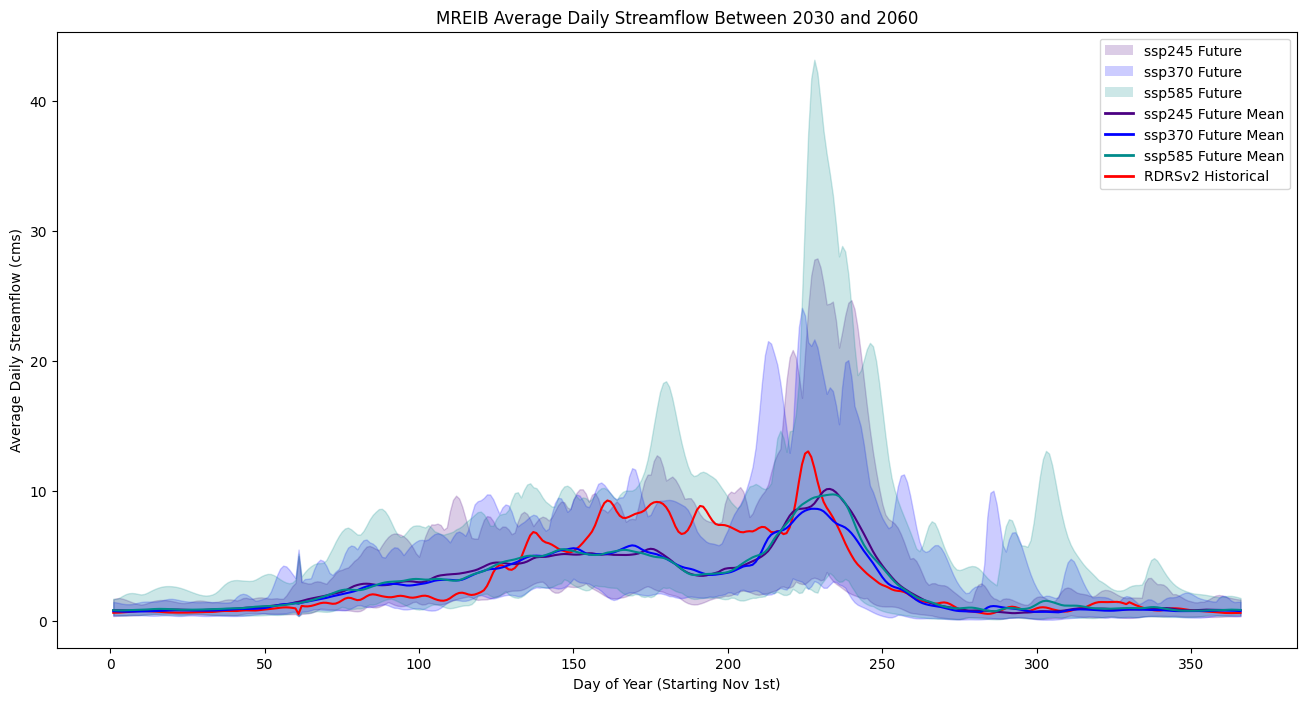

In [16]:
# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Plotting each member directly with specified colors and labels
ssp245_2030.plot.line(x='dayofyear', color='purple', alpha=0, label='_nolegend_')
ssp370_2030.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp585_2030.plot.line(x='dayofyear', color='orange', alpha=0, label='_nolegend_')
sim_resampled.plot(label='Simulated Historical', color='red')

# Fill between lines
plt.fill_between(ssp245_2030['dayofyear'], ssp245_2030.min(dim='member'), ssp245_2030.max(dim='member'), color='indigo', alpha=0.2)
plt.fill_between(ssp370_2030['dayofyear'], ssp370_2030.min(dim='member'), ssp370_2030.max(dim='member'), color='blue', alpha=0.2)
plt.fill_between(ssp585_2030['dayofyear'], ssp585_2030.min(dim='member'), ssp585_2030.max(dim='member'), color='darkcyan', alpha=0.2)

# Plot the mean of each ensemble
ssp245_2060_mean = ssp245_2030.mean(dim='member')
ssp370_2060_mean = ssp370_2030.mean(dim='member')
ssp585_2060_mean = ssp585_2030.mean(dim='member')

ssp245_2060_mean.plot(color='indigo', linestyle='-', label='ssp245 Future Mean')
ssp370_2060_mean.plot(color='blue', linestyle='-', label='ssp370 Future Mean')
ssp585_2060_mean.plot(color='darkcyan', linestyle='-', label='ssp585 Future Mean')

# Manually create legend handles and labels
legend_handles = [
    Patch(facecolor='indigo', alpha=0.2, label=f'ssp245 Future'),
    Patch(facecolor='blue', alpha=0.2, label=f'ssp370 Future'),
    Patch(facecolor='darkcyan', alpha=0.2, label=f'ssp585 Future'),
    Line2D([0], [0], color='indigo', lw=2, linestyle='-', label='ssp245 Future Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='ssp370 Future Mean'),
    Line2D([0], [0], color='darkcyan', lw=2, linestyle='-', label='ssp585 Future Mean'),
        Line2D([0], [0], color='red', lw=2, label='RDRSv2 Historical')
]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.xlabel('Day of Year (Starting Nov 1st)')
plt.ylabel(f'Average Daily {var_name} (cms)')
plt.title(f'{gauge_name} Average Daily {var_name} Between 2030 and 2060')

# Save the plot as PNG
plt.savefig(f'{subbasin_id}_2030_all_ssp_.png')

plt.show()

2060-2090

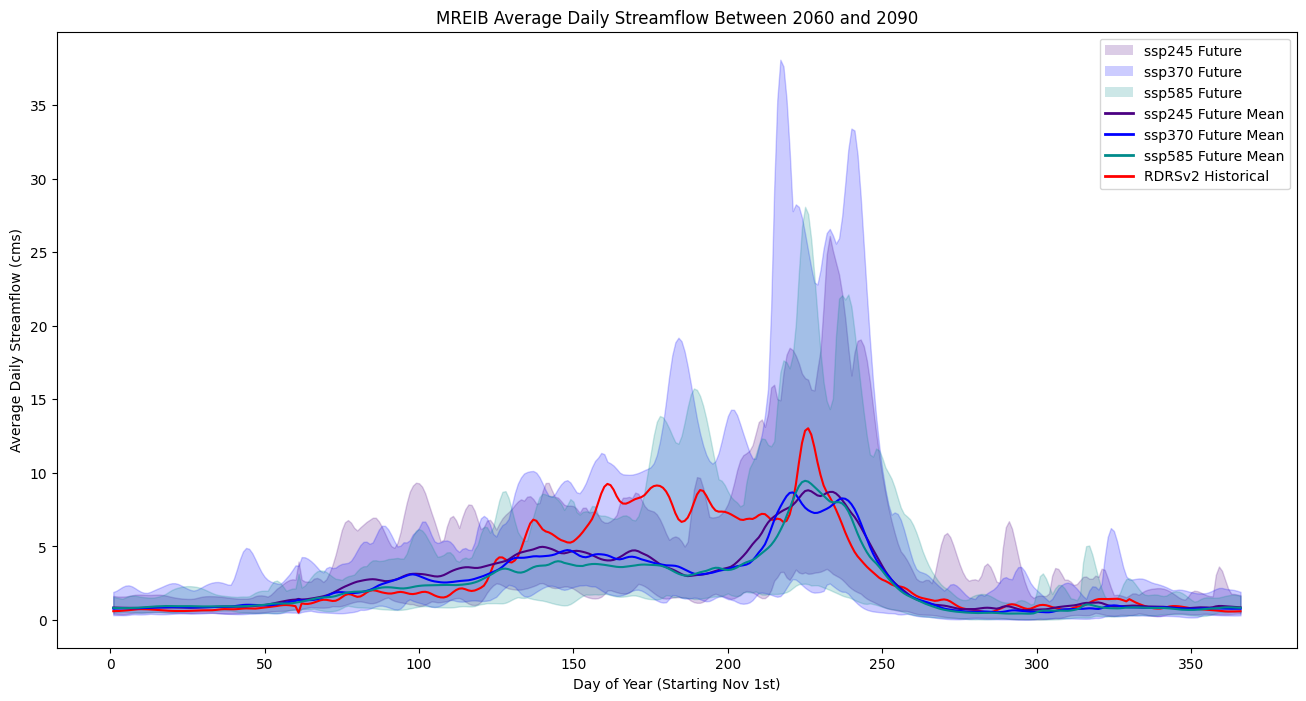

In [17]:
# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Plotting each member directly with specified colors and labels
ssp245_2060.plot.line(x='dayofyear', color='purple', alpha=0, label='_nolegend_')
ssp370_2060.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp585_2060.plot.line(x='dayofyear', color='orange', alpha=0, label='_nolegend_')
sim_resampled.plot(label='Simulated Historical', color='red')

# Fill between lines
plt.fill_between(ssp245_2060['dayofyear'], ssp245_2060.min(dim='member'), ssp245_2060.max(dim='member'), color='indigo', alpha=0.2)
plt.fill_between(ssp370_2060['dayofyear'], ssp370_2060.min(dim='member'), ssp370_2060.max(dim='member'), color='blue', alpha=0.2)
plt.fill_between(ssp585_2060['dayofyear'], ssp585_2060.min(dim='member'), ssp585_2060.max(dim='member'), color='darkcyan', alpha=0.2)

# Plot the mean of each ensemble
ssp245_2060_mean = ssp245_2060.mean(dim='member')
ssp370_2060_mean = ssp370_2060.mean(dim='member')
ssp585_2060_mean = ssp585_2060.mean(dim='member')

ssp245_2060_mean.plot(color='indigo', linestyle='-', label='ssp245 Future Mean')
ssp370_2060_mean.plot(color='blue', linestyle='-', label='ssp370 Future Mean')
ssp585_2060_mean.plot(color='darkcyan', linestyle='-', label='ssp585 Future Mean')

# Manually create legend handles and labels
legend_handles = [
    Patch(facecolor='indigo', alpha=0.2, label=f'ssp245 Future'),
    Patch(facecolor='blue', alpha=0.2, label=f'ssp370 Future'),
    Patch(facecolor='darkcyan', alpha=0.2, label=f'ssp585 Future'),
    Line2D([0], [0], color='indigo', lw=2, linestyle='-', label='ssp245 Future Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='ssp370 Future Mean'),
    Line2D([0], [0], color='darkcyan', lw=2, linestyle='-', label='ssp585 Future Mean'),
        Line2D([0], [0], color='red', lw=2, label='RDRSv2 Historical')
]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.xlabel('Day of Year (Starting Nov 1st)')
plt.ylabel(f'Average Daily {var_name} (cms)')
plt.title(f'{gauge_name} Average Daily {var_name} Between 2060 and 2090')

# Save the plot as PNG
plt.savefig(f'{subbasin_id}_2060_all_ssp_.png')

plt.show()

### Individual ssp over time

ssp245

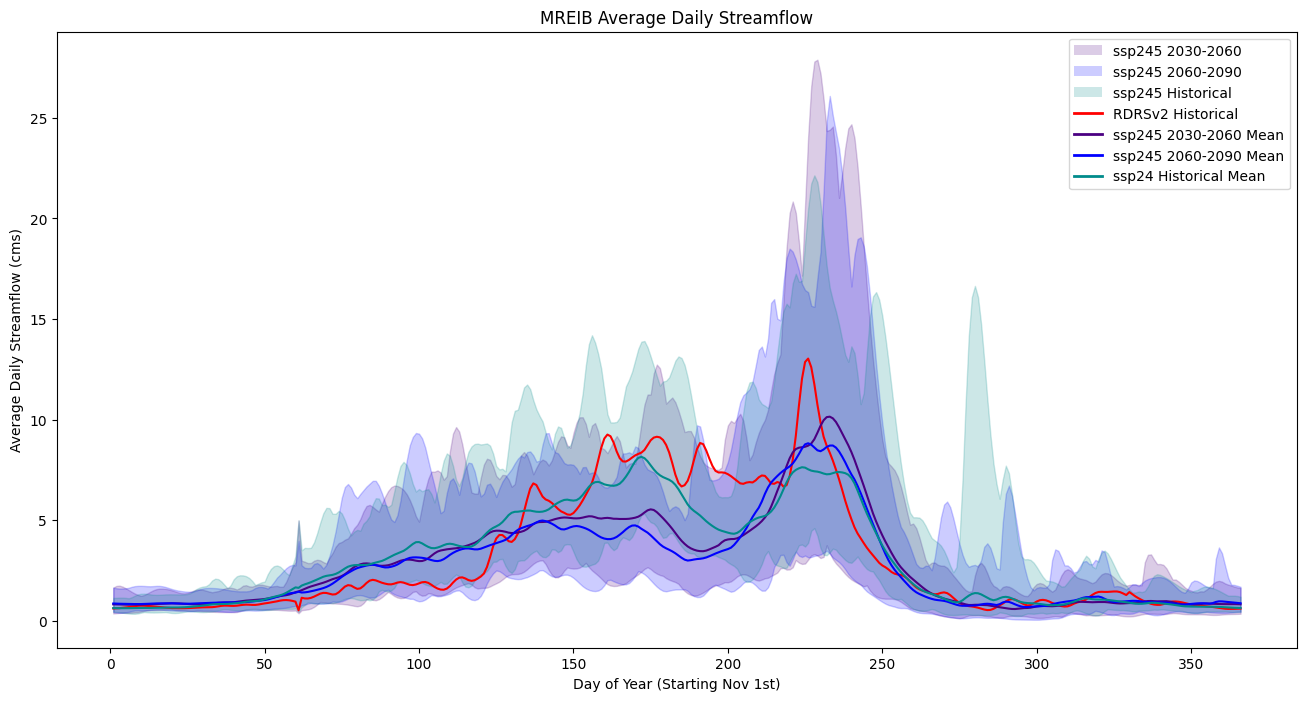

In [18]:
# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Plotting each member directly with specified colors and labels
ssp245_2030.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp245_2060.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp245_historical.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
sim_resampled.plot(label='Simulated Historical', color='red')

# Fill between lines
plt.fill_between(ssp245_2030['dayofyear'], ssp245_2030.min(dim='member'), ssp245_2030.max(dim='member'), color='indigo', alpha=0.2)
plt.fill_between(ssp245_2060['dayofyear'], ssp245_2060.min(dim='member'), ssp245_2060.max(dim='member'), color='blue', alpha=0.2)
plt.fill_between(ssp245_historical['dayofyear'], ssp245_historical.min(dim='member'), ssp245_historical.max(dim='member'), color='darkcyan', alpha=0.2)

# Plot the mean of each ensemble
ssp245_2030_mean = ssp245_2030.mean(dim='member')
ssp245_2060_mean = ssp245_2060.mean(dim='member')
ssp245_historical_mean = ssp245_historical.mean(dim='member')

ssp245_2030_mean.plot(color='indigo', linestyle='-', label='ssp245 2030-2060 Mean')
ssp245_2060_mean.plot(color='blue', linestyle='-', label='ssp245 2060-2090 Mean')
ssp245_historical_mean.plot(color='darkcyan', linestyle='-', label='ssp245 Historical Mean')


# Manually create legend handles and labels
legend_handles = [
    Patch(facecolor='indigo', alpha=0.2, label=f'ssp245 2030-2060'),
    Patch(facecolor='blue', alpha=0.2, label=f'ssp245 2060-2090'),
    Patch(facecolor='darkcyan', alpha=0.2, label=f'ssp245 Historical'),
    Line2D([0], [0], color='red', lw=2, label='RDRSv2 Historical'),
    Line2D([0], [0], color='indigo', lw=2, linestyle='-', label='ssp245 2030-2060 Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='ssp245 2060-2090 Mean'),
    Line2D([0], [0], color='darkcyan', lw=2, linestyle='-', label='ssp24 Historical Mean')
]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.xlabel('Day of Year (Starting Nov 1st)')
plt.ylabel(f'Average Daily {var_name} (cms)')
plt.title(f'{gauge_name} Average Daily {var_name}')

# Save the plot as PNG
plt.savefig(f'{subbasin_id}_ssp_245_all_time_periods_.png')

plt.show()


ssp370

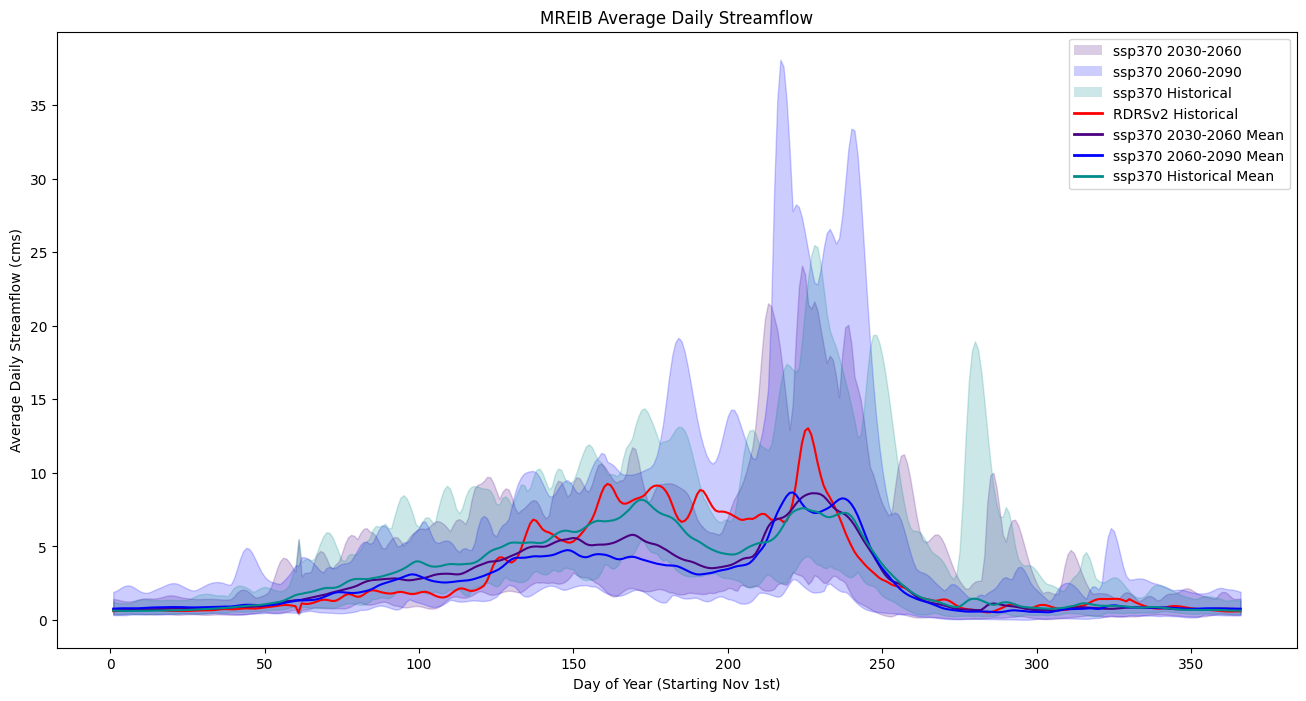

In [19]:
# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Plotting each member directly with specified colors and labels
ssp370_2030.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp370_2060.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp370_historical.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
sim_resampled.plot(label='Simulated Historical', color='red')

# Fill between lines
plt.fill_between(ssp370_2030['dayofyear'], ssp370_2030.min(dim='member'), ssp370_2030.max(dim='member'), color='indigo', alpha=0.2)
plt.fill_between(ssp370_2060['dayofyear'], ssp370_2060.min(dim='member'), ssp370_2060.max(dim='member'), color='blue', alpha=0.2)
plt.fill_between(ssp370_historical['dayofyear'], ssp370_historical.min(dim='member'), ssp370_historical.max(dim='member'), color='darkcyan', alpha=0.2)

# Plot the mean of each ensemble
ssp370_2030_mean = ssp370_2030.mean(dim='member')
ssp370_2060_mean = ssp370_2060.mean(dim='member')
ssp370_historical_mean = ssp370_historical.mean(dim='member')

ssp370_2030_mean.plot(color='indigo', linestyle='-', label='ssp370 2030-2060 Mean')
ssp370_2060_mean.plot(color='blue', linestyle='-', label='ssp370 2060-2090 Mean')
ssp370_historical_mean.plot(color='darkcyan', linestyle='-', label='ssp370 Historical Mean')


# Manually create legend handles and labels
legend_handles = [
    Patch(facecolor='indigo', alpha=0.2, label=f'ssp370 2030-2060'),
    Patch(facecolor='blue', alpha=0.2, label=f'ssp370 2060-2090'),
    Patch(facecolor='darkcyan', alpha=0.2, label=f'ssp370 Historical'),
    Line2D([0], [0], color='red', lw=2, label='RDRSv2 Historical'),
    Line2D([0], [0], color='indigo', lw=2, linestyle='-', label='ssp370 2030-2060 Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='ssp370 2060-2090 Mean'),
    Line2D([0], [0], color='darkcyan', lw=2, linestyle='-', label='ssp370 Historical Mean')
]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.xlabel('Day of Year (Starting Nov 1st)')
plt.ylabel(f'Average Daily {var_name} (cms)')
plt.title(f'{gauge_name} Average Daily {var_name}')

# Save the plot as PNG
plt.savefig(f'{subbasin_id}_ssp_370_all_time_periods_.png')

plt.show()


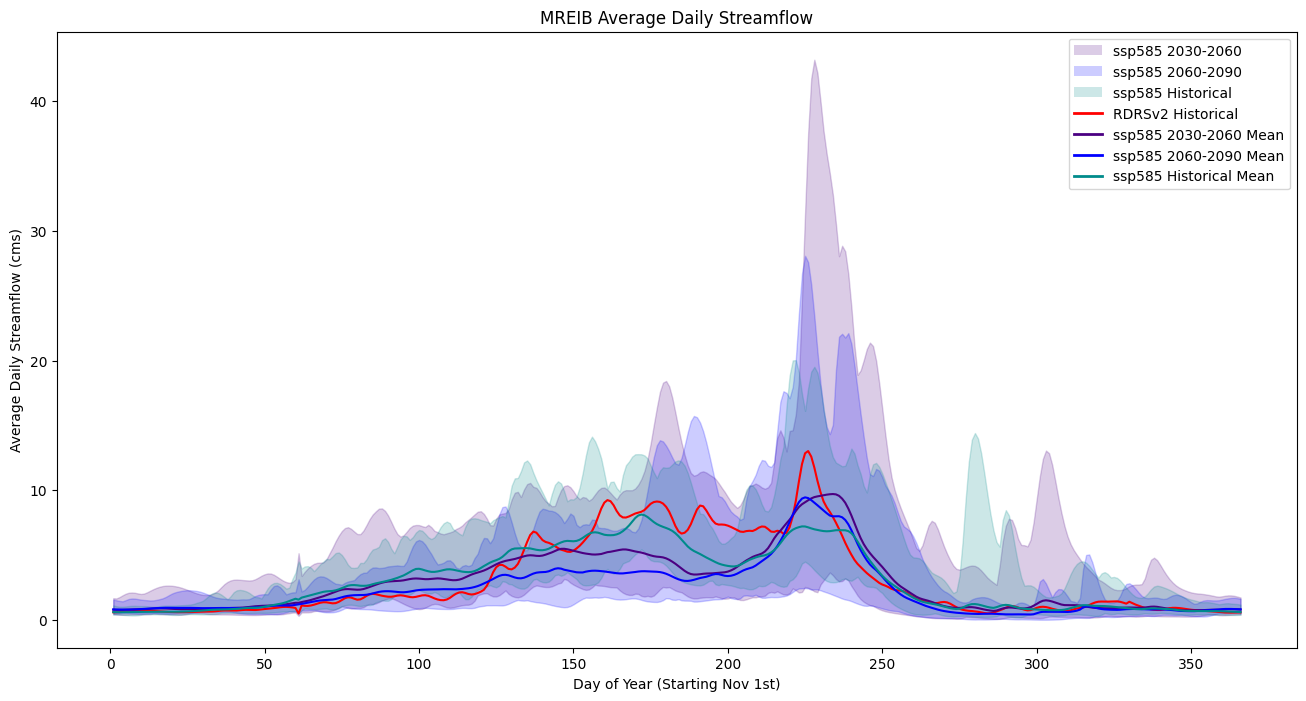

In [20]:
# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Plotting each member directly with specified colors and labels
ssp585_2030.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp585_2060.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
ssp585_historical.plot.line(x='dayofyear', color='blue', alpha=0, label='_nolegend_')
sim_resampled.plot(label='Simulated Historical', color='red')

# Fill between lines
plt.fill_between(ssp585_2030['dayofyear'], ssp585_2030.min(dim='member'), ssp585_2030.max(dim='member'), color='indigo', alpha=0.2)
plt.fill_between(ssp585_2060['dayofyear'], ssp585_2060.min(dim='member'), ssp585_2060.max(dim='member'), color='blue', alpha=0.2)
plt.fill_between(ssp585_historical['dayofyear'], ssp585_historical.min(dim='member'), ssp585_historical.max(dim='member'), color='darkcyan', alpha=0.2)

# Plot the mean of each ensemble
ssp585_2030_mean = ssp585_2030.mean(dim='member')
ssp585_2060_mean = ssp585_2060.mean(dim='member')
ssp585_historical_mean = ssp585_historical.mean(dim='member')

ssp585_2030_mean.plot(color='indigo', linestyle='-', label='ssp585 2030-2060 Mean')
ssp585_2060_mean.plot(color='blue', linestyle='-', label='ssp585 2060-2090 Mean')
ssp585_historical_mean.plot(color='darkcyan', linestyle='-', label='ssp585 Historical Mean')


# Manually create legend handles and labels
legend_handles = [
    Patch(facecolor='indigo', alpha=0.2, label=f'ssp585 2030-2060'),
    Patch(facecolor='blue', alpha=0.2, label=f'ssp585 2060-2090'),
    Patch(facecolor='darkcyan', alpha=0.2, label=f'ssp585 Historical'),
    Line2D([0], [0], color='red', lw=2, label='RDRSv2 Historical'),
    Line2D([0], [0], color='indigo', lw=2, linestyle='-', label='ssp585 2030-2060 Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='ssp585 2060-2090 Mean'),
    Line2D([0], [0], color='darkcyan', lw=2, linestyle='-', label='ssp585 Historical Mean')
]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.xlabel('Day of Year (Starting Nov 1st)')
plt.ylabel(f'Average Daily {var_name} (cms)')
plt.title(f'{gauge_name} Average Daily {var_name}')

# Save the plot as PNG
plt.savefig(f'{subbasin_id}_ssp_585_all_time_periods_.png')

plt.show()
